# Purpose:



## Imports:

In [2]:
import IPython

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp

import mpld3
# mpld3.enable_notebook()

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 60)
# import tables as h5

import itertools as it
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
from scikits import bootstrap as bs
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
from statsmodels.nonparametric.smoothers_lowess import lowess

import munch

import pymc as mc

from shapely.geometry import LineString

from spartan.utils.genome_specific.GfusI1 import GfusI1_0
from spartan.utils.fastas import ParseFastA

from gs_ddRAD2015.scripts import ld_figures as ldfigs

In [123]:
# set figure characteristics

# size
sns.set_context("poster")

# Grid style
sns.set_style("whitegrid")

# colors
sns.set_palette("colorblind")

## File paths:

In [5]:
# define paths to files
out_dir = "/home/gus/MEGAsync/projects/ddRAD_phase2/repos/ddRAD_phase2/scratch/gs_2015_ld/OT_MS_NB_indiv.geno.ld"

## Loading files

In [6]:
figs = ldfigs.Figures(out_dir=out_dir, formats='png')

In [7]:
figs.load_data_tables()


ld_figures: loading data_tables.




In [8]:
tables = munch.Munch(figs.d)
tables.keys()

['ld',
 'd_bins',
 'contig_info',
 'd_bin_v_others_melt',
 'len_contigs_per_bin',
 'd_bin_v_others',
 'contigs_per_bin',
 'mean_bin_r2_all',
 'sp_contigs',
 'ld_contig']

In [9]:
ld = tables.ld
ld.head()

,Unnamed: 0,Unnamed: 0.1,CHR_A,BP_A,BP_B,N_INDV,R2,BP_DELTA,distance_bin,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded
0,0,0,Scaffold0,13388,23408,48,1.000000,10020,10000,0.999500,NaN,NaN,1.000000,0.000000,NaN,False
1,1,1,Scaffold0,13388,23418,48,1.000000,10030,10000,0.999500,NaN,NaN,1.000000,0.000000,NaN,False
2,2,2,Scaffold0,13388,23421,48,1.000000,10033,10000,0.999500,NaN,NaN,1.000000,0.000000,NaN,False
3,3,3,Scaffold0,13388,23431,48,0.975315,10043,10000,0.974840,NaN,NaN,0.999662,0.000338,NaN,False
4,4,4,Scaffold0,13388,30544,49,0.366428,17156,17150,0.366562,NaN,NaN,0.862496,0.137504,NaN,False


In [10]:
def get_halfing_coords(xs, ys, num, tolerance):
    xs_return = []
    ys_return = []
    
    halfing_values = get_n_halfing_values(val=ys[0],n=num)[1:]
    
    for value in halfing_values:
        indexes_close_to_yi = get_indexes_close_to_yi(ys=ys, value=value, tolerance=tolerance)
        middle_item = get_first_item(indexes=indexes_close_to_yi)
        if middle_item is None:
            print 'None'
        else:
            # print indexes_close_to_yi
            # print xs[middle_item]
            # print ys[middle_item]
            xs_return.append(xs[middle_item])
            ys_return.append(ys[middle_item])
    
    return xs_return,ys_return
    
def get_indexes_close_to_yi(ys, value, tolerance):
    ilist = []
    for i,y in enumerate(ys):
        if abs(value-y) <= tolerance:
            ilist.append(i)
    return ilist
    
def get_n_halfing_values(val, n):
    rvalues = []
    c_val = val
    for i in range(n+1):
        c_val = c_val/2.0
        rvalues.append(c_val)
    return rvalues
        
def get_middle_item(indexes):
    if len(indexes) == 0:
        return None
    return indexes[int(len(indexes)/2)]

def get_first_item(indexes):
    if len(indexes) == 0:
        return None
    return indexes[0]

# Distance bt snp-pair vs R^2 all:

In [11]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [12]:
d_bin_v_others_melt = figs.d.d_bin_v_others_melt

In [40]:
# mpld3.enable_notebook()
# mpld3.disable_notebook()

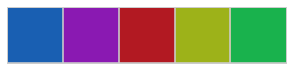

In [191]:
# pal = sns.choose_colorbrewer_palette("q")

# pal = sns.husl_palette(n_colors=4, h=0.6, s=0.9, l=0.65)
pal = sns.hls_palette(n_colors=5, h=0.59, l=0.4, s=0.75)
sns.palplot(pal)

# pal = sns.choose_cubehelix_palette()

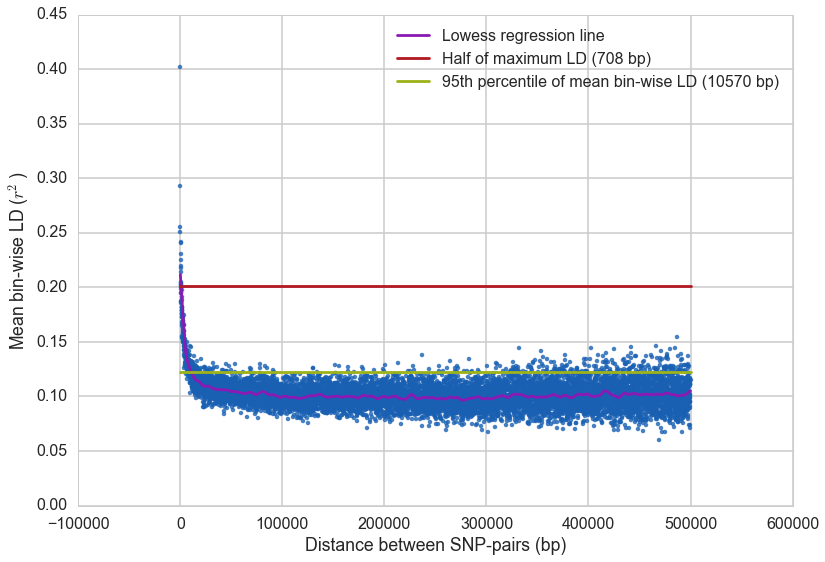

In [196]:
sns.set_palette(pal)

melted_r2 = d_bin_v_others_melt.query("variable == 'R2'").query("0 <= distance_bin <= 500000")

d = melted_r2.distance_bin

r2 = melted_r2.value
r2_95centile = r2.quantile(.95)

rgplt = sns.regplot(d, r2, data=None, x_estimator=None, x_bins=None, x_ci=95, 
            scatter=True, fit_reg=False, ci=95, n_boot=10000, 
            units=None, order=1, logistic=False, lowess=True, robust=False, 
            logx=False, x_partial=None, y_partial=None, 
            truncate=False, dropna=True, x_jitter=None, y_jitter=None, 
            xlabel=None, ylabel=None, label=None, 
            color=None, marker='o', 
            scatter_kws=None, line_kws=None, ax=None)

# plt.plot(d,
#          movingaverage(interval=r2, window_size=6),
#          color='coral', alpha=0.3);

# lowess regression
delta = 0.01 * len(d)
r2_lowess = lowess(r2,d,frac=0.02, it=0, delta=delta)
r2_half = r2.max()/2.


centile_line = [[0,r2_95centile],[r2_lowess[-1][0],r2_95centile]]
halfing_line = [[0,r2_half],[r2_lowess[-1][0],r2_half]]

halfing_geo = LineString(halfing_line)
centile_geo = LineString(centile_line)
lowess_geo = LineString(r2_lowess)

isect_c = centile_geo.intersection(lowess_geo)
isect_h = halfing_geo.intersection(lowess_geo)

isect_c_x,isect_c_y = int(round(isect_c.x)), isect_c.y
isect_h_x,isect_h_y = int(round(isect_h.x)), isect_h.y

plt.plot(d,
         r2_lowess[:,1],
         alpha=1,
         label="Lowess regression line");

plt.plot([x[0] for x in halfing_line],
         [y[1] for y in halfing_line],  
         label=u"Half of maximum LD ({isect} bp)".format(isect=isect_h_x),
         alpha=1
        )

plt.plot([x[0] for x in centile_line],
         [y[1] for y in centile_line], 
         label="95th percentile of mean bin-wise LD ({isect} bp)".format(isect=isect_c_x),
         alpha=1
        )




# plt.plot(0,0,label="test3",alpha=0)

# plt.scatter(x=xs_hlf, y=ys_hlf, 
#             s=200, c=u'k', marker=u'x', 
#             alpha=None, linewidths=2);

dummy_plug = plt.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

plt.xlabel(r"Distance between SNP-pairs (bp)")
plt.ylabel(r"Mean bin-wise LD ($r^2$)")



plt.legend()

# print "xs_hlf, ys_hlf: ",xs_hlf, ys_hlf 



In [49]:
r2_half

0.20085498707277499

In [48]:
melted_r2.head()

,Unnamed: 0,distance_bin,variable,value
0,0,0,R2,0.401710
1,1,50,R2,0.293258
2,2,100,R2,0.255214
3,3,150,R2,0.250560
4,4,200,R2,0.230920


# Distance vs R2 (scaffold0)

In [52]:
def get_melted_by_scaff(df,scaff_name):
    df_scaf = df.query("CHR_A == '{scaff_name}'".format(scaff_name=scaff_name)).pivot_table(index=['distance_bin'],
                                               values=['R2'],
                                               aggfunc=[np.mean]
                                               )['mean'].reset_index()
    return pd.melt(df_scaf, id_vars=['distance_bin'])

In [55]:
melted_scaf0 = get_melted_by_scaff(ld,'Scaffold0')
melted_scaf0.head()

,distance_bin,variable,value
0,0,R2,0.560982
1,50,R2,0.308072
2,100,R2,0.514498
3,150,R2,0.009752
4,200,R2,0.468399


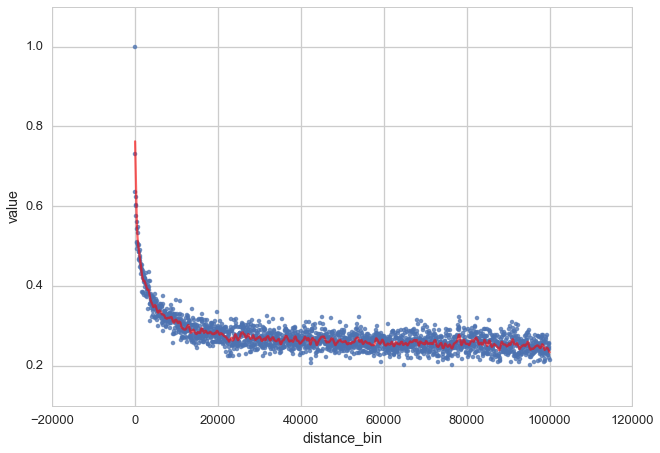

In [53]:
melted_r2 = d_bin_v_others_melt.query("variable == 'R2'").query("0 <= distance_bin <= 100000")

d = melted_r2.distance_bin

r2 = melted_r2.value
rgplt = sns.regplot(d, r2, data=None, x_estimator=None, x_bins=None, x_ci=95, 
            scatter=True, fit_reg=False, ci=95, n_boot=10000, 
            units=None, order=1, logistic=False, lowess=True, robust=False, 
            logx=False, x_partial=None, y_partial=None, 
            truncate=False, dropna=True, x_jitter=None, y_jitter=None, 
            xlabel=None, ylabel='R2', label='lable', 
            color=None, marker='o', 
            scatter_kws=None, line_kws=dict(color='r'), ax=None)

# plt.plot(d,
#          movingaverage(interval=r2, window_size=6),
#          color='coral', alpha=0.3);

# lowess regression
delta = 0.01 * len(d)
r2_lowess = lowess(r2,d,frac=0.01, it=0, delta=delta)
plt.plot(d,
        r2_lowess[:,1],
        color='red', alpha=0.6);


xs_hlf,ys_hlf = get_halfing_coords(xs=d, ys=r2_lowess[:,1], num=1, tolerance=0.1)

plt.scatter(x=xs_hlf, y=ys_hlf, 
            s=200, c=u'k', marker=u'x', 
            alpha=None, linewidths=2);
print xs_hlf, ys_hlf 

In [121]:
pdb

Automatic pdb calling has been turned OFF


In [94]:
print(gicty)

[221, 222, 223, 224, 225, 226, 227, 228, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262]


In [97]:
gicty[int(len(gicty)/2)]

252

In [60]:
rr2_lowess[53,1]

0.4000919238750073

# Learning the exponetial decay parameters (fitting the decay)

#### Exponential decay equation: 

$$N(t) = N_0 e^{-\lambda t}$$

Here $N(t)$  is the quantity at time $t$, and $N_0 = N(0)$ is the initial quantity, i.e. the quantity at time $t = 0$.

### From the distance_bin set

In [195]:
def get_model_err(df):


    r2_0 = df[df.distance_bin == df.distance_bin.min()].value.iloc[0]

    # the model we are tying to solve for is:
    # N_at_t = N0*e^-(lamb*t) * err
    # y = N0*e^-(lamb*x) * err
    # r2 = N0*e^-(lamb*d) * err


    N0 = r2_0
    e = np.e
    
    x = mc.Uniform("distance", lower=df.distance_bin.min(), upper=df.distance_bin.max(), 
                   value=np.array(df.distance_bin), observed=True)
    
    lamb = mc.Normal("lambda", 25, 0.0000001)
    
    err = mc.Normal("error", 21, 0.0000001)
    
    @mc.deterministic
    def pred(N0=N0, lamb=lamb, x=x,e=e, err=err):
        return N0*e**(-lamb*x) * err
    
    y = mc.Normal("r2", pred, 0.00001, value=np.array(df.value), observed=True)
    
    model = mc.Model([N0,e,x,lamb,err,pred,y])
    return model

In [196]:
1/0.000001

1000000.0

In [197]:
melted_r2 = d_bin_v_others_melt.query("variable == 'R2'").query("50 <= distance_bin <= 1000")

In [200]:
m = get_model_err(melted_r2)
mod_graph = mc.graph.graph(m)
mod_graph.write_png('2015-06-04_LD_ploting_THREE_pops_NO_KG.exponetial_decay_model.png')
decay_MAP = mc.MAP(m)
decay_MAP.fit()
print "MAP error: ", m.get_node('error').value
print "MAP lambda: ", m.get_node('lambda').value
print "MAP halflife: ", np.log(2)/m.get_node('lambda').value

MAP error:  210.000000055
MAP lambda:  24.9999972193
MAP halflife:  0.0277258903063


In [201]:
mcmc = mc.MCMC(m)

 [-----------------100%-----------------] 50000 of 50000 complete in 10.3 secPlotting error
Plotting lambda
MCMC error:  956.745834147
MCMC lambda:  4154.25851106
MCMC halflife:  0.000166852202075


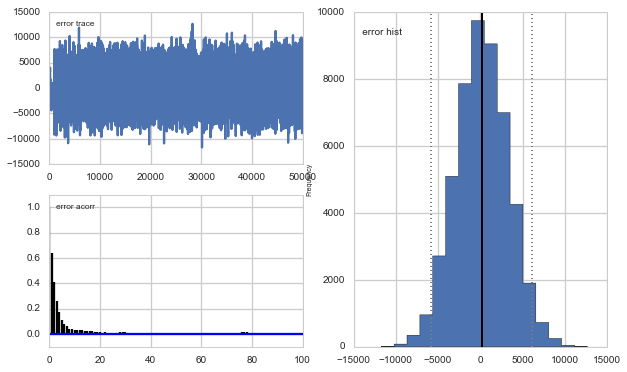

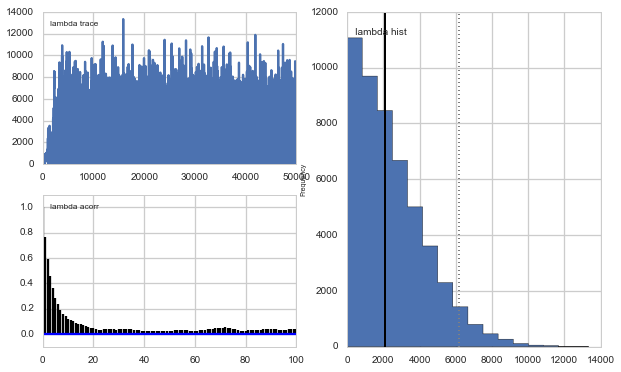

In [202]:
mcmc.sample(50000, 10, thin=1)
mc.Matplot.plot(mcmc)
print "MCMC error: ", m.get_node('error').value
print "MCMC lambda: ", m.get_node('lambda').value
print "MCMC halflife: ", np.log(2)/m.get_node('lambda').value

In [41]:
half_life = np.log(2)/277811451.2547393
half_life

2.4950273915252102e-09

In [32]:
def get_model_noerr(df):


    r2_0 = df[df.distance_bin == df.distance_bin.min()].value.iloc[0]

    # the model we are tying to solve for is:
    # N_at_t = N0*e^-(lamb*t)
    # y = N0*e^-(lamb*x)
    # r2 = N0*e^-(lamb*d)


    N0 = r2_0
    e = np.e
    
    x = mc.Uniform("distance", lower=df.distance_bin.min(), upper=df.distance_bin.max(), 
                   value=np.array(df.distance_bin), observed=True)
    
    lamb = mc.Normal("lambda", , 1000000000)
    
#     err = mc.Normal("error", 0, 0.00001)
    
    @mc.deterministic
    def pred(N0=N0, lamb=lamb, x=x,e=e):
        return N0*e**(-lamb*x)
    
    y = mc.Normal("r2", pred, 0.0000001, value=np.array(df.value), observed=True)
    
    model = mc.Model([N0,e,x,lamb,pred,y])
    return model

In [34]:
m = get_model_noerr(melted_r2)
mod_graph = mc.graph.graph(m)
mod_graph.write_png('2015-06-04_LD_ploting_THREE_pops_NO_KG.exponetial_decay_model.png')
decay_MAP = mc.MAP(m)
decay_MAP.fit()
print "lambda: ", m.get_node('lambda').value
mcmc = mc.MCMC(m)

lambda:  595064540.847


In [ ]:
mcmc.sample(50000, 30000, thin=2)

In [39]:
melted_r2.query("distance_bin == 600")

,Unnamed: 0,distance_bin,variable,value
12,12,600,R2,0.201728


In [38]:
melted_r2.query("distance_bin == 200000")

,Unnamed: 0,distance_bin,variable,value
4000,4000,200000,R2,0.103567


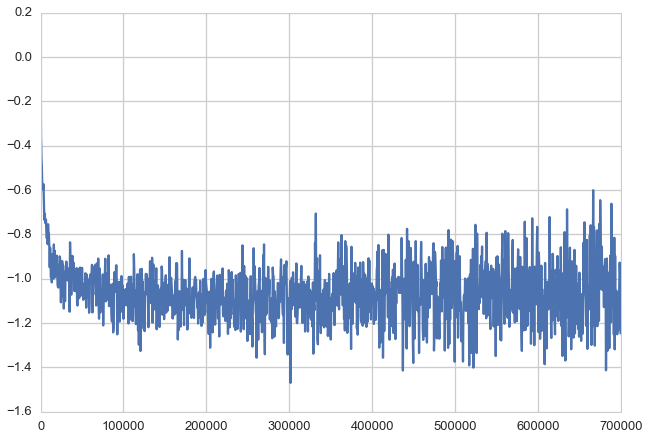

In [16]:
ith = 10
d = melted_r2.distance_bin[::ith]
rr2 = melted_r2.value[::ith]/melted_r2.value[::ith]
ln_rr2 = np.log(r2[::ith])
plt.plot(d,ln_rr2);

In [97]:
r2 = melted_r2.value

# set initial values of Gamma's alpha and beta to be E[X]_gamma(a,b)
alpha_of_gamma = np.log(2)
beta_of_gamma = r2.median()

lambda_est = alpha_of_gamma/beta_of_gamma

print "alpha_of_gamma: {alpha_of_gamma}\nbeta_of_gamma: {beta_of_gamma}\nlambda_est: {lambda_est}".format(
    alpha_of_gamma=alpha_of_gamma,
    beta_of_gamma=beta_of_gamma,
    lambda_est=lambda_est)

alpha_of_gamma: 0.69314718056
beta_of_gamma: 0.101198127996
lambda_est: 6.8494071411


In [98]:
lambda_of_exponential = mc.Gamma(name='lambda_of_exponential', alpha=alpha_of_gamma, beta=beta_of_gamma)
lambda_of_exponential.value = lambda_est
lambda_of_exponential.value

array(6.849407141102154)

In [99]:
r2_decay_exponential = mc.Exponential("r2_decay",
                                      beta=lambda_of_exponential,
                                      value=r2, observed=True)

In [100]:
model = mc.Model([r2_decay_exponential, lambda_of_exponential])
map_est = mc.MAP(model)
map_est.fit()

In [109]:
map_est_lambda = float(lambda_of_exponential.value)

In [110]:
map_est_lambda

9.754141038980423

In [111]:
# MCMC = mc.MCMC(model)

In [112]:
# MCMC.sample(iter=40000, burn=20000, thin=1)

 [-----------------100%-----------------] 40000 of 40000 complete in 117.6 sec

Plotting lambda_of_exponential


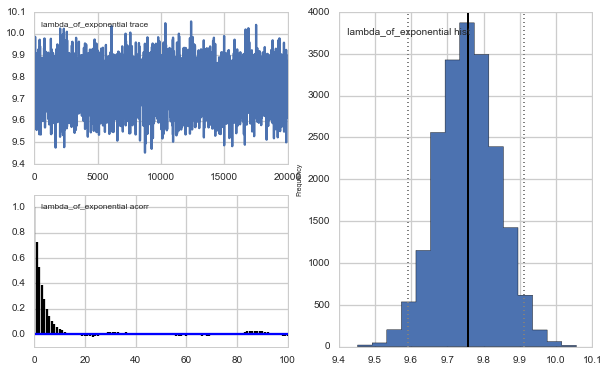

In [113]:
# mc.Matplot.plot(MCMC)

### From https://fabiomarroni.wordpress.com/2011/08/09/estimate-decay-of-linkage-disequilibrium-with-distance/

In [203]:
import rpy2.robjects as robjects